# Transformer Sign2Gloss

## Imports

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import string
import re

tf.get_logger().setLevel('ERROR')

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
#@title Selecione o modelo: { form-width: "50%" }
WORKSPACE = "orth" #@param ["translation", "orth"] {allow-input: true}

In [11]:
batch_size = 20

# Número total de épocas para treinar o modelo
N_EPOCHS = 100

# Número de épocas de aquecimento
N_WARMUP_EPOCHS = 5

# Taxa de aprendizado máxima
LR_MAX = 1e-3

# Proporção de decaimento de peso (weight decay)
WD_RATIO = 0.05

# Método de aquecimento
WARMUP_METHOD = "exp"

FRAME_LEN = 250

pad_token_idx = 0
vocab_size = 2890 if WORKSPACE == 'translation' else 1085
sequence_length = 35 if WORKSPACE == 'translation' else 20

## Data

In [4]:
train_corpus_df = pd.read_csv('annotations/PHOENIX-2014-T.train.corpus.csv', sep='|')
test_corpus_df = pd.read_csv('annotations/PHOENIX-2014-T.test.corpus.csv', sep='|')
dev_corpus_df = pd.read_csv('annotations/PHOENIX-2014-T.dev.corpus.csv', sep='|')

In [8]:
def create_dataset(df, kps_path):
    """
    Cria um tf.data.Dataset com o caminho do arquivo de keypoints e a frase associada.

    Args:
    - df: DataFrame com os dados
    - kps_path: Caminho para a pasta com os arquivos de keypoints

    Returns:
    tf.data.Dataset com a estrutura (caminho_do_arquivo, frase)
    """
    # Filtra as linhas do dataframe onde o arquivo de keypoints associado existe
    valid_rows = [i for i, row in df.iterrows() if os.path.exists(os.path.join(kps_path, row['name'] + '.npy'))]
    filtered_df = df.iloc[valid_rows]

    # Cria listas de caminhos de arquivo e legendas usando o dataframe filtrado
    paths = [os.path.join(kps_path, row['name'] + '.npy') for _, row in filtered_df.iterrows()]
    captions = filtered_df[WORKSPACE].values

    dataset = tf.data.Dataset.from_tensor_slices((paths, captions))
    return dataset

In [12]:
# Caminhos para os arquivos de keypoints de treino, teste e dev
train_kps_path = 'kps/train/'
test_kps_path = 'kps/test/'
dev_kps_path = 'kps/dev/'

# Criar os tf.data.Datasets
train_raw = create_dataset(train_corpus_df, train_kps_path)
test_raw = create_dataset(test_corpus_df, test_kps_path)
dev_raw = create_dataset(dev_corpus_df, dev_kps_path)

In [8]:
for ex_path, ex_caption in train_raw.take(1):
    print(ex_path)
    print(ex_caption)

tf.Tensor(b'kps/train/11August_2010_Wednesday_tagesschau-1.npy', shape=(), dtype=string)
tf.Tensor(b'JETZT WETTER MORGEN DONNERSTAG ZWOELF FEBRUAR', shape=(), dtype=string)


## Tokenizer

In [16]:
def standardize_caption(s):
    s = tf.strings.upper(s)
    s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
    return s

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    standardize=standardize_caption,
    output_mode="int",
    output_sequence_length=sequence_length,
    ragged=False
)

tokenizer.adapt(train_corpus_df[WORKSPACE].to_numpy())

@tf.function
def tokenize_function(path, caption):
    tokenized_caption = tokenizer(caption)
    return path, tokenized_caption

In [11]:
# Salvar apenas os pesos do tokenizador em um arquivo
import numpy as np

# Salvar os pesos do tokenizador em um arquivo numpy
np.save('tokenizer_weights.npy', tokenizer.get_weights())

## Augmatation

In [13]:
@tf.function
def spatial_random_affine(keypoints, 
                          scale_range = (0.8, 1.2), 
                          rotation_range = (-30, 30), 
                          shear_range = (-0.15, 0.15), 
                          translation_range = (-0.1, 0.1)):
    
    keypoints = tf.convert_to_tensor(keypoints, dtype=tf.float32)

    # Escala
    if scale_range is not None:
        scale_factor = tf.random.uniform([], scale_range[0], scale_range[1])
        keypoints *= scale_factor

    # Cisalhamento
    if shear_range is not None:
        xy = keypoints[..., :2]
        z = keypoints[..., 2:]
        shear_factor_x, shear_factor_y = tf.random.uniform([], shear_range[0], shear_range[1]), tf.random.uniform([], shear_range[0], shear_range[1])
        if tf.random.uniform([]) < 0.5:
            shear_factor_x = 0.
        else:
            shear_factor_y = 0.
        shear_matrix = tf.convert_to_tensor([
            [1, shear_factor_x],
            [shear_factor_y, 1]
        ], dtype=tf.float32)
        xy = tf.matmul(xy, shear_matrix)
        keypoints = tf.concat([xy, z], axis=-1)

    # Rotação
    if rotation_range is not None:
        xy = keypoints[..., :2]
        z = keypoints[..., 2:]
        center = tf.constant([0.5, 0.5], dtype=tf.float32)
        xy -= center
        angle = tf.random.uniform([], rotation_range[0], rotation_range[1])
        theta = angle * np.pi / 180  # Convertendo de graus para radianos
        c = tf.cos(theta)
        s = tf.sin(theta)
        rotation_matrix = tf.convert_to_tensor([
            [c, -s],
            [s, c]
        ], dtype=tf.float32)
        xy = tf.matmul(xy, rotation_matrix)
        xy += center
        keypoints = tf.concat([xy, z], axis=-1)

    # Translação
    if translation_range is not None:
        translation = tf.random.uniform([1, 3], translation_range[0], translation_range[1])
        keypoints += translation

    return keypoints

@tf.function
def interp1d_(x, target_len, method='random'):
    length = tf.shape(x)[1]
    target_len = tf.maximum(1,target_len)
    if method == 'random':
        if tf.random.uniform(()) < 0.33:
            x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'bilinear')
        else:
            if tf.random.uniform(()) < 0.5:
                x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'bicubic')
            else:
                x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'nearest')
    else:
        x = tf.image.resize(x, (target_len,tf.shape(x)[1]),method)
    return x

@tf.function
def resample(x, rate=(0.8,1.2)):
  rate = tf.random.uniform((), rate[0], rate[1])
  length = tf.shape(x)[0]
  new_size = tf.cast(rate*tf.cast(length,tf.float32), tf.int32)
  new_x = interp1d_(x, new_size)
  return new_x

## Landmarks PreProcess

In [14]:
@tf.function
def normalize(keypoints):
    keypoints = tf.reshape(keypoints, [-1, keypoints.shape[1] * keypoints.shape[2]])
    mean, variance = tf.nn.moments(keypoints, [-1], keepdims=True)
    normalized_keypoints = tf.nn.batch_normalization(keypoints, mean, variance, offset=None, scale=None, variance_epsilon=1e-6)
    return normalized_keypoints

@tf.function
def resize_pad(x):
    num_frames = tf.shape(x)[0]
    if num_frames < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN - num_frames], [0, 0], [0, 0]]), constant_values=0.0)
    else:
        x = tf.image.resize(x, [FRAME_LEN, tf.shape(x)[1]], method=tf.image.ResizeMethod.AREA)
    return x

def load_and_normalize_keypoints_train(file_path):
    keypoints = tf.convert_to_tensor(np.load(file_path.numpy().decode('utf-8')), dtype=tf.float32)
    keypoints = spatial_random_affine(keypoints)
    keypoints = resample(keypoints)
    keypoints = resize_pad(keypoints)
    keypoints = normalize(keypoints)
    return keypoints

def load_and_normalize_keypoints_dev_test(file_path):
    keypoints = tf.convert_to_tensor(np.load(file_path.numpy().decode('utf-8')), dtype=tf.float32)
    keypoints = resize_pad(keypoints)
    keypoints = normalize(keypoints)
    return keypoints

def tf_load_and_normalize_keypoints_train(file_path, label):
    keypoints = tf.py_function(load_and_normalize_keypoints_train, [file_path], tf.float32)
    return keypoints, label

def tf_load_and_normalize_keypoints_dev_test(file_path, label):
    keypoints = tf.py_function(load_and_normalize_keypoints_dev_test, [file_path], tf.float32)
    return keypoints, label

In [17]:
# Pipeline de treinamento atualizado
train_dataset = (train_raw.map(tokenize_function)
                          .map(tf_load_and_normalize_keypoints_train)
                          .batch(batch_size))  

# Pipelines de desenvolvimento e teste permanecem os mesmos
dev_dataset = (dev_raw.map(tokenize_function)
                       .map(tf_load_and_normalize_keypoints_dev_test)
                       .batch(batch_size))

test_dataset = (test_raw.map(tokenize_function)
                        .map(tf_load_and_normalize_keypoints_dev_test)
                        .batch(batch_size))

In [18]:
def inspect_dataset_shape(dataset):
    for keypoints, captions in dataset.take(1):
        print("Keypoints Shape:", keypoints.shape)
        print("Captions Shape:", captions.shape)
        return keypoints.shape, captions.shape

# Obtém o próximo lote de dados do conjunto de validação usando o iterador
batch = next(iter(train_dataset))

# Calcula a forma das entradas de dados no lote
INPUT_SHAPE = batch[0].shape[1:]

print("Train Dataset:")
train_shape = inspect_dataset_shape(train_dataset)
print("\nDev Dataset:")
dev_shape = inspect_dataset_shape(dev_dataset)
print("\nTest Dataset:")
test_shape = inspect_dataset_shape(test_dataset)

Train Dataset:
Keypoints Shape: (20, 250, 177)
Captions Shape: (20, 20)

Dev Dataset:
Keypoints Shape: (20, 250, 177)
Captions Shape: (20, 20)

Test Dataset:
Keypoints Shape: (20, 250, 177)
Captions Shape: (20, 20)


## Transformer Model

In [14]:
class ECA(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=kernel_size, strides=1, padding="same", use_bias=False)

    def call(self, inputs, mask=None):
        """
        Realiza uma operação ECA (Enhanced Channel Attention) em tensores de entrada.

        Args:
            inputs (tf.Tensor): Tensor de entrada.
            mask (tf.Tensor, opcional): Tensor de máscara para suportar sequências com comprimentos diferentes.

        Returns:
            tf.Tensor: Tensor após a operação ECA.
        """
        nn = tf.keras.layers.GlobalAveragePooling1D()(inputs, mask=mask)
        nn = tf.expand_dims(nn, -1)
        nn = self.conv(nn)
        nn = tf.squeeze(nn, -1)
        nn = tf.nn.sigmoid(nn)
        nn = nn[:, None, :]
        return inputs * nn

In [15]:
class MaskingDWConv1D(tf.keras.layers.Layer):
    '''
    masked DW1Dconv with strides>1, padding=same.
    NOTE: padded(masked) frames should always be at the beginning or end of the input sequence.
    '''
    def __init__(self, kernel_size, strides=1,
        dilation_rate=1,
        padding='same',
        use_bias=False,
        kernel_initializer='glorot_uniform',**kwargs):
        super().__init__(**kwargs)
        assert padding == 'same' or padding == 'causal'
        self.strides = strides
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.use_bias = use_bias
        self.padding = padding
        self.conv = tf.keras.layers.DepthwiseConv1D(
                            kernel_size,
                            strides=strides,
                            dilation_rate=dilation_rate,
                            padding=padding,
                            use_bias=use_bias,
                            kernel_initializer=kernel_initializer)
        self.supports_masking = True

    def compute_mask(self, inputs, mask=None):
      if mask is not None:
        if self.strides > 1:
          mask = mask[:,::self.strides]
      return mask

    def call(self, inputs, mask=None):
        x = inputs
        if mask is not None:
            x = tf.where(mask[...,None], x, tf.constant(0., dtype=x.dtype))
        x = self.conv(x)
        return x

In [16]:
def Conv1DBlock(channel_size,
                kernel_size,
                dilation_rate=1,
                drop_rate=0.0,
                expand_ratio=2,
                se_ratio=0.25,
                activation='tanh',
                name=None):
    '''
    Efetua uma operação de bloco conv1d eficiente.

    Args:
        channel_size (int): Número de canais de saída.
        kernel_size (int): Tamanho do kernel da convolução.
        dilation_rate (int, opcional): Taxa de dilatação para convolução causal. Padrão é 1.
        drop_rate (float, opcional): Taxa de dropout. Padrão é 0.0.
        expand_ratio (int, opcional): Fator de expansão do canal. Padrão é 2.
        se_ratio (float, opcional): Taxa de excitação espacial (SE). Padrão é 0.25.
        activation (str, opcional): Função de ativação. Padrão é 'swish'.
        name (str, opcional): Nome da camada. Padrão é None.

    Returns:
        Callable: Função que aplica o bloco conv1d eficiente.
    '''
    if name is None:
        name = str(tf.keras.backend.get_uid("mbblock"))
    # Fase de expansão
    def apply(inputs):
        channels_in = tf.keras.backend.int_shape(inputs)[-1]
        channels_expand = channels_in * expand_ratio

        skip = inputs

        x = tf.keras.layers.Dense(
            channels_expand,
            use_bias=True,
            activation=activation,
            name=name + '_expand_conv')(inputs)

        # Convolução Depthwise
        x = MaskingDWConv1D(kernel_size,
                           dilation_rate=dilation_rate,
                           use_bias=False,
                           name=name + '_dwconv')(x)

        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn')(x)

        x = ECA()(x)

        x = tf.keras.layers.Dense(
            channel_size,
            use_bias=True,
            name=name + '_project_conv')(x)

        if drop_rate > 0:
            x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None, 1, 1), name=name + '_drop')(x)

        if (channels_in == channel_size):
            x = tf.keras.layers.add([x, skip], name=name + '_add')
        return x

    return apply

In [17]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, dim=256, num_heads=4, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.scale = self.dim ** -0.5
        self.num_heads = num_heads
        self.qkv = tf.keras.layers.Dense(3 * dim, use_bias=False)
        self.drop1 = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(dim, use_bias=False)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        qkv = self.qkv(inputs)
        qkv = tf.keras.layers.Permute((2, 1, 3))(
            tf.keras.layers.Reshape((-1, self.num_heads, self.dim * 3 // self.num_heads))(qkv))
        q, k, v = tf.split(qkv, [self.dim // self.num_heads] * 3, axis=-1)

        # Calcula a atenção.
        attn = tf.matmul(q, k, transpose_b=True) * self.scale

        if mask is not None:
            mask = mask[:, None, None, :]

        attn = tf.keras.layers.Softmax(axis=-1)(attn, mask=mask)
        attn = self.drop1(attn)

        x = attn @ v
        x = tf.keras.layers.Reshape((-1, self.dim))(
            tf.keras.layers.Permute((2, 1, 3))(x))
        x = self.proj(x)
        return x

In [18]:
def TransformerBlock(dim=256, num_heads=4, expand=4, attn_dropout=0.2, drop_rate=0.2, activation='swish'):
    """
    Bloco de Transformer personalizado.

    Args:
        dim (int): Dimensão do espaço de características.
        num_heads (int): Número de cabeças de atenção multi-head.
        expand (int): Fator de expansão para a camada densa interna.
        attn_dropout (float): Taxa de dropout para a camada de atenção multi-head.
        drop_rate (float): Taxa de dropout para as camadas de dropout.
        activation (str): Função de ativação para as camadas densas internas.

    Returns:
        Callable: Função que aplica o bloco de Transformer a um tensor de entrada.
    """
    def apply(inputs):
        reshaped_inputs = tf.keras.layers.Dense(dim, use_bias=False)(inputs)
        x = reshaped_inputs
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        x = MultiHeadSelfAttention(dim=dim, num_heads=num_heads, dropout=attn_dropout)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None, 1, 1))(x)
        x = tf.keras.layers.Add()([reshaped_inputs, x])
        attn_out = x  

  
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        x = tf.keras.layers.Dense(dim * expand, use_bias=False, activation=activation)(x)
        x = tf.keras.layers.Dense(dim, use_bias=False)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None, 1, 1))(x)
        x = tf.keras.layers.Add()([attn_out, x])
        return x

    return apply

In [19]:
def positional_encoding(maxlen, num_hid):
    """
    Gera a codificação posicional para sequências de entrada.

    Args:
        maxlen (int): Comprimento máximo da sequência.
        num_hid (int): Número de dimensões ocultas para a codificação posicional.

    Returns:
        tf.Tensor: Codificação posicional para a sequência de entrada.
    """
    depth = num_hid / 2
    positions = tf.range(maxlen, dtype=tf.float32)[..., tf.newaxis]
    depths = tf.range(depth, dtype=tf.float32)[np.newaxis, :] / depth
    angle_rates = tf.math.divide(1, tf.math.pow(tf.cast(10000, tf.float32), depths))
    angle_rads = tf.linalg.matmul(positions, angle_rates)

    # Calcula as funções trigonométricas para a codificação posicional.
    sin_vals = tf.math.sin(angle_rads)
    cos_vals = tf.math.cos(angle_rads)

    # Concatena as funções seno e cosseno para formar a codificação posicional.
    pos_encoding = tf.concat([sin_vals, cos_vals], axis=-1)
    return pos_encoding

In [20]:
class CTCLoss(tf.keras.losses.Loss):
    def __init__(self, blank_index=0, input_padding_value=0., target_padding_value=0, **kwargs):
        super().__init__(**kwargs)
        self.blank_index = blank_index
        self.input_padding_value = input_padding_value
        self.target_padding_value = target_padding_value

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.float32)
        batch_len = tf.cast(tf.shape(y_true)[0], dtype=tf.int32)
        label_length = y_true != tf.cast(self.target_padding_value, tf.int32)
        label_length = tf.reduce_sum(tf.cast(label_length, tf.int32), axis=1, keepdims=False) #(B,)
        mask = getattr(y_pred, '_keras_mask', None)
        if mask is not None:
            input_length = tf.reduce_sum(tf.cast(mask, tf.int32), axis=-1)
        else:
            input_length = tf.cast(tf.shape(y_pred)[1], dtype=tf.int32)
            input_length = input_length * tf.ones(shape=(batch_len,), dtype=tf.int32)

        loss = tf.nn.ctc_loss(y_true, y_pred, label_length=label_length, logit_length=input_length, blank_index=0, logits_time_major=False)

        loss = tf.reduce_mean(loss)

        return loss
    
class MaskedSCCE(tf.keras.losses.Loss):
    def __init__(self, num_classes=vocab_size, from_logits=True, label_smoothing=0.25, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.label_smoothing=label_smoothing
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        mask = y_true!=0
        N = tf.shape(y_true)[0]
        y_pred = tf.cast(y_pred, tf.float32)
        y_true = tf.one_hot(y_true, self.num_classes, axis=-1, dtype=tf.float32)
        loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=self.from_logits, label_smoothing=self.label_smoothing)
        loss = tf.where(mask, loss, tf.constant(0, dtype=tf.float32))
        loss = tf.reduce_sum(loss)
        loss = loss / tf.cast(N, tf.float32)
        return loss

In [21]:
def get_model(dim=192, vocab_size=len(tokenizer.get_vocabulary())):

    inp = tf.keras.Input(INPUT_SHAPE)
    x = tf.keras.layers.Masking(mask_value=0.0)(inp)  
    x = tf.keras.layers.Dense(dim, use_bias=False, name='stem_conv')(x)  
    pe = tf.cast(positional_encoding(INPUT_SHAPE[0], dim), dtype=x.dtype)  
    x = x + pe  
    x = tf.keras.layers.BatchNormalization(momentum=0.95, name='stem_bn')(x)  

    num_blocks = 4  # Número de blocos no modelo.
    drop_rate = 0.2  # Taxa de dropout.

    for i in range(num_blocks):
        x = Conv1DBlock(dim, 11, drop_rate=drop_rate)(x)
        x = Conv1DBlock(dim, 5, drop_rate=drop_rate)(x)
        x = Conv1DBlock(dim, 3, drop_rate=drop_rate)(x)
        x = TransformerBlock(dim, expand=2)(x)
    x = tf.keras.layers.Dense(dim * 2, activation='relu', name='top_conv')(x)  # Camada densa intermediária.
    x = tf.keras.layers.Dropout(0.4)(x)  # Dropout.
    x = tf.keras.layers.Dense(vocab_size, name='classifier')(x)  # Camada de classificação.

    model = tf.keras.Model(inp, x)  # Cria o modelo.
    ctc_loss = CTCLoss()  # Função de perda CTC.

    # Otimizador Adam com retificação e lookahead.
    optimizer = tfa.optimizers.RectifiedAdam(sma_threshold=4)
    optimizer = tfa.optimizers.Lookahead(optimizer, sync_period=5)
    optimizer = tfa.optimizers.AdamW(learning_rate=4e-3, weight_decay=1e-4)

    model.compile(loss=ctc_loss, optimizer=optimizer)  # Compila o modelo.

    return model

In [22]:
tf.keras.backend.clear_session()
model = get_model()
model(batch[0])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 177)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 250, 177)     0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Dense)              (None, 250, 192)     33984       ['masking[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 250, 192)    0           ['stem_conv[0][0]']              
 da)                                                                                          

In [5]:
def decode_phrase(pred, tokenizer):
    """
    Decodifica uma previsão da rede neural em uma sequência de tokens.

    Args:
        pred (tf.Tensor): Tensor contendo as previsões da rede neural.
        tokenizer (tf.keras.layers.TextVectorization): Tokenizador.

    Returns:
        List[str]: Lista de tokens decodificados.
    """
    # Obter o índice do token com a maior probabilidade para cada posição
    x = tf.argmax(pred, axis=1)
    # Remover índices consecutivos idênticos
    diff = tf.not_equal(x[:-1], x[1:])
    adjacent_indices = tf.where(diff)[:, 0]
    x = tf.gather(x, adjacent_indices)
    # Remover o índice do token de padding
    mask = x != pad_token_idx
    x = tf.boolean_mask(x, mask, axis=0)
    return x

def decode_batch_predictions(pred, tokenizer):
    """
    Decodifica as previsões da rede neural em uma lista de frases.

    Args:
        pred (List[tf.Tensor]): Lista de tensores contendo as previsões da rede neural.
        tokenizer (tf.keras.layers.TextVectorization): O tokenizador.

    Returns:
        List[str]: Lista de frases decodificadas.
    """
    output_text = []
    for result in pred:
        tokens = decode_phrase(result, tokenizer).numpy()
        # Converter tokens para palavras
        vocab = tokenizer.get_vocabulary()
        decoded_sentence = [vocab[token] for token in tokens]
        # Juntar palavras
        sentence = " ".join(decoded_sentence)
        output_text.append(sentence)
    return output_text

In [24]:
def beam_search(pred, tokenizer, beam_width=5):
    decoded_batch = []
    vocab = tokenizer.get_vocabulary()

    for logit in pred:
        if len(logit.shape) == 2:
            logit = tf.expand_dims(logit, 0)

        logit = tf.transpose(logit, perm=[1, 0, 2])
        decoded, log_prob = tf.nn.ctc_beam_search_decoder(
            logit,
            sequence_length=tf.fill([tf.shape(logit)[1]], tf.shape(logit)[0]),
            beam_width=beam_width
        )

        dense_decoded = tf.sparse.to_dense(decoded[0], default_value=pad_token_idx)
        dense_decoded = dense_decoded.numpy()
        dense_decoded = [seq[seq != pad_token_idx] for seq in dense_decoded]

        decoded_text = [' '.join([vocab[idx] for idx in seq]) for seq in dense_decoded]

        # Se todas as sequências estiverem vazias, tenta encontrar as três palavras mais prováveis
        if not any(decoded_text):
            generated_words = []
            for time_step in logit.numpy():
                top_indices = np.argsort(time_step[0])[-3:][::-1]  # Busca as três palavras mais prováveis
                for idx in top_indices:
                    if idx != pad_token_idx and len(generated_words) < 3:
                        word = vocab[idx]
                        if word:  # Verifica se a palavra encontrada não é vazia
                            generated_words.append(word)
                    if len(generated_words) == 3:
                        break
                if len(generated_words) == 3:
                    break
            decoded_text = [' '.join(generated_words)] if generated_words else ["Texto padrão"]

        decoded_batch.append(decoded_text)

    return decoded_batch

In [6]:
class CallbackEval(tf.keras.callbacks.Callback):
    """
    Uma classe de callback para exibir algumas transcrições durante o treinamento.

    Args:
        dataset (tf.data.Dataset): O conjunto de dados de validação para avaliar as transcrições.
        tokenizer (tf.keras.layers.TextVectorization): O tokenizador.
    """

    def __init__(self, dataset, tokenizer):
        super().__init__()
        self.dataset = dataset
        self.tokenizer = tokenizer

    def on_epoch_end(self, epoch: int, logs=None):
        """
        Método chamado no final de cada época durante o treinamento.

        Args:
            epoch (int): O número da época atual.
            logs: Dicionário contendo as métricas de treinamento.
        """
        # Salva os pesos do modelo após cada época
        self.model.save_weights("model.h5")

        predictions = []  # Armazena as transcrições previstas
        targets = []  # Armazena as transcrições reais

        # Loop através dos lotes do conjunto de dados de validação
        for batch in self.dataset:
            X, y = batch
            batch_predictions = self.model(X)  # Obtém previsões para o lote
            batch_predictions = decode_batch_predictions(batch_predictions, self.tokenizer)  # Decodifica as previsões
            predictions.extend(batch_predictions)  # Adiciona as previsões à lista
            for label in y:
                # Converte os rótulos em sequências de palavras
                decoded_label = " ".join([self.tokenizer.get_vocabulary()[idx] for idx in label.numpy()])
                targets.append(decoded_label)  # Adiciona os rótulos à lista de metas

        print("-" * 100)

        # Exibe transcrições de um subconjunto aleatório de exemplos (32 no total)
        for i in range(8):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}, len: {len(predictions[i].split())}")
            print("-" * 100)

In [26]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    """
    Função para calcular a taxa de aprendizado com base no número de passos e configurações fornecidas.

    Args:
        current_step (int): O número atual de passos de treinamento.
        num_warmup_steps (int): O número de passos de aquecimento.
        lr_max (float): A taxa de aprendizado máxima.
        num_cycles (float): O número de ciclos de oscilação cíclica.
        num_training_steps (int): O número total de passos de treinamento.

    Returns:
        float: A taxa de aprendizado calculada para o passo atual.
    """
    # Verifica se o passo atual está antes do período de aquecimento
    if current_step < num_warmup_steps:
        # Verifica o método de aquecimento (log ou exponencial)
        if WARMUP_METHOD == 'log':
            # Taxa de aprendizado diminui exponencialmente durante o período de aquecimento
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            # Taxa de aprendizado diminui exponencialmente durante o período de aquecimento (método padrão)
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        # Calcula o progresso do treinamento após o período de aquecimento
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        # Calcula a taxa de aprendizado com base no cosseno com oscilações
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

In [27]:
def plot_lr_schedule(lr_schedule, epochs):
    """
    Função para traçar um gráfico da programação da taxa de aprendizado ao longo das épocas.

    Args:
        lr_schedule (list): Uma lista de taxas de aprendizado ao longo das épocas.
        epochs (int): O número total de épocas.

    Returns:
        None
    """
    # Cria uma figura para o gráfico
    fig = plt.figure(figsize=(20, 10))

    # Plota as taxas de aprendizado com rótulos
    plt.plot([None] + lr_schedule + [None])

    # Rótulos do eixo X
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels)  # define o passo do rótulo para 1 e começa o eixo x em 1

    # Aumenta o limite y para melhor legibilidade
    plt.ylim([0, max(lr_schedule) * 1.1])

    # Título do gráfico
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)

    # Plota as taxas de aprendizado com rótulos
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black')
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)

    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

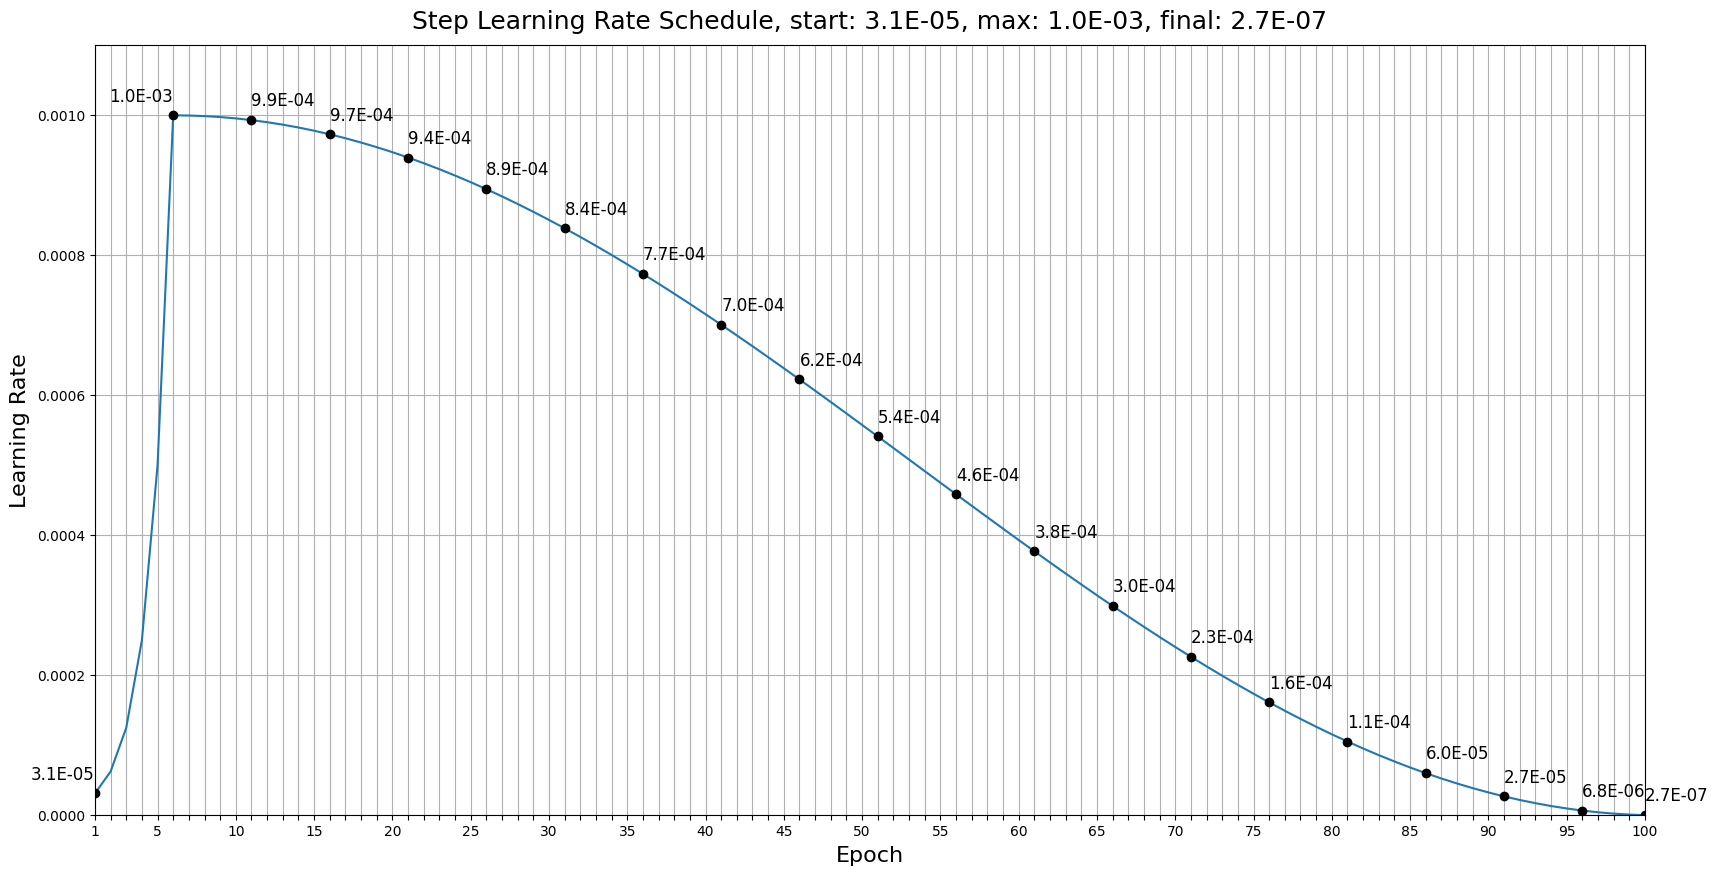

In [28]:
# Função de callback para verificar a transcrição no conjunto de validação.
validation_callback = CallbackEval(dev_dataset, tokenizer)
# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)

# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio

    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

In [30]:
# Lista existente de callbacks
callbacks_list = [
    validation_callback,
    lr_callback,
    WeightDecayCallback(),
    #wandb.keras.WandbCallback(save_model=True, monitor='val_loss', mode='min')  # Salvar o melhor modelo com base na perda de validação
]

# Treinamento do modelo
history = model.fit(
    train_dataset,
    validation_data=dev_dataset,
    epochs=N_EPOCHS,
    callbacks=callbacks_list
)

learning rate: 3.13e-05, weight decay: 1.56e-06
Epoch 1/100
355/355 [==============================] - ETA: 0s - loss: 49.0057----------------------------------------------------------------------------------------------------
Target    : DRUCK TIEF KOMMEN                 
Prediction: , len: 0
----------------------------------------------------------------------------------------------------
Target    : ESBEDEUTET VIEL WOLKE UND KOENNEN REGEN GEWITTER KOENNEN            
Prediction: , len: 0
----------------------------------------------------------------------------------------------------
Target    : WIND MAESSIG SCHWACH REGION WENN GEWITTER WIND KOENNEN            
Prediction: , len: 0
----------------------------------------------------------------------------------------------------
Target    : MITTWOCH REGEN KOENNEN NORDWEST WAHRSCHEINLICH NORD STARK WIND            
Prediction: , len: 0
--------------------------------------------------------------------------------------------

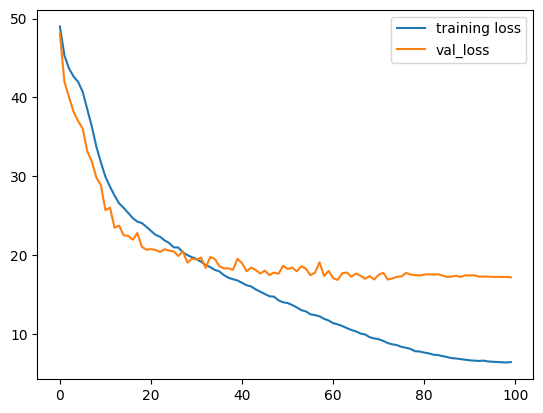

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'val_loss'])

In [32]:
# Fazer previsões no conjunto de dados de validação (dev_dataset)
predictions_dev  = []  # Armazena as transcrições previstas
targets_dev = []  # Armazena as transcrições reais

# Loop através dos lotes do conjunto de dados de validação
for batch in dev_dataset:
    X, y = batch
    batch_predictions = model(X)  # Obtém previsões para o lote
    batch_predictions = decode_batch_predictions(batch_predictions, tokenizer)  # Decodifica as previsões
    predictions_dev .extend(batch_predictions)  # Adiciona as previsões à lista
    for label in y:
        # Converte os rótulos em sequências de palavras
        decoded_label = " ".join([tokenizer.get_vocabulary()[idx] for idx in label.numpy()])
        targets_dev.append(decoded_label)  # Adiciona os rótulos à lista de metas

# Exibe transcrições previstas e rótulos reais
for i in range(len(predictions_dev )):
    print(f"Target    : {targets_dev[i]}")
    print(f"Prediction: {predictions_dev [i]}, len: {len(predictions_dev [i].split())}")
    print("-" * 100)

Target    : DRUCK TIEF KOMMEN                 
Prediction: DRUCK TIEF, len: 2
----------------------------------------------------------------------------------------------------
Target    : ESBEDEUTET VIEL WOLKE UND KOENNEN REGEN GEWITTER KOENNEN            
Prediction: IX WOLKE KOENNEN REGEN GEWITTER KOENNEN, len: 6
----------------------------------------------------------------------------------------------------
Target    : WIND MAESSIG SCHWACH REGION WENN GEWITTER WIND KOENNEN            
Prediction: WIND MAESSIG SCHWACH SUED NORD UND GEWITTER STURM KOENNEN, len: 9
----------------------------------------------------------------------------------------------------
Target    : MITTWOCH REGEN KOENNEN NORDWEST WAHRSCHEINLICH NORD STARK WIND            
Prediction: MITTWOCH REGEN KOENNEN NORDWEST NORD STARK STURM, len: 7
----------------------------------------------------------------------------------------------------
Target    : JETZT WETTER WIEAUSSEHEN MORGEN FREITAG SECHSTE MAI 

In [33]:
# Fazer previsões no conjunto de dados de validação (test_dataset)
predictions_test = []  # Armazena as transcrições previstas
targets_test = []  # Armazena as transcrições reais = []  # Armazena as transcrições previstas

# Loop através dos lotes do conjunto de dados de validação
for batch in test_dataset:
    X, y = batch
    batch_predictions = model(X)  # Obtém previsões para o lote
    batch_predictions = decode_batch_predictions(batch_predictions, tokenizer)  # Decodifica as previsões
    predictions_test.extend(batch_predictions)  # Adiciona as previsões à lista
    for label in y:
        # Converte os rótulos em sequências de palavras
        decoded_label = " ".join([tokenizer.get_vocabulary()[idx] for idx in label.numpy()])
        targets_test.append(decoded_label)  # Adiciona os rótulos à lista de metas

# Exibe transcrições previstas e rótulos reais
for i in range(len(predictions_test)):
    print(f"Target    : {targets_test[i]}")
    print(f"Prediction: {predictions_test[i]}, len: {len(predictions_test[i].split())}")
    print("-" * 100)

Target    : REGEN SCHNEE REGION VERSCHWINDEN NORD REGEN KOENNEN REGION STERN KOENNEN SEHEN         
Prediction: REGEN SCHNEE REGION TATSAECHLICH NORD REGEN KOENNEN REGION REGION STERN STERN KOENNEN SEHEN, len: 13
----------------------------------------------------------------------------------------------------
Target    : DONNERSTAG NORDWEST REGEN REGION SONNE WOLKE WECHSELHAFT DANN FREITAG AEHNLICH WETTER         
Prediction: DONNERSTAG NORD REGEN REGION SONNE WOLKE WECHSELHAFT DANN MORGEN WECHSELHAFT WETTER, len: 11
----------------------------------------------------------------------------------------------------
Target    : KRAEFTIG AB MORGEN FRUEH MEISTENS SCHNEE SCHNEIEN KALT REGEN           
Prediction: EIS AB MORGEN SCHNEE SCHNEIEN FROST REGEN, len: 7
----------------------------------------------------------------------------------------------------
Target    : WOCHENENDE SONNE SAMSTAG SCHOEN TEMPERATUR BIS SIEBZEHN GRAD REGION           
Prediction: SONNE SAMSTAG GRAD BIS 

## Computar o Bleu

In [23]:
import collections
import math


def _get_ngrams(segment, max_order):
    """Extracts all n-grams upto a given maximum order from an input segment.

    Args:
      segment: text segment from which n-grams will be extracted.
      max_order: maximum length in tokens of the n-grams returned by this
          methods.

    Returns:
      The Counter containing all n-grams upto max_order in segment
      with a count of how many times each n-gram occurred.
    """
    ngram_counts = collections.Counter()
    for order in range(1, max_order + 1):
        for i in range(0, len(segment) - order + 1):
            ngram = tuple(segment[i:i + order])
            ngram_counts[ngram] += 1
    return ngram_counts


def compute_bleu(reference_corpus, translation_corpus, max_order=4,
                 smooth=False):
    """Computes BLEU score of translated segments against one or more references.

    Args:
      reference_corpus: list of lists of references for each translation. Each
          reference should be tokenized into a list of tokens.
      translation_corpus: list of translations to score. Each translation
          should be tokenized into a list of tokens.
      max_order: Maximum n-gram order to use when computing BLEU score.
      smooth: Whether or not to apply Lin et al. 2004 smoothing.

    Returns:
      3-Tuple with the BLEU score, n-gram precisions, geometric mean of n-gram
      precisions and brevity penalty.
    """
    matches_by_order = [0] * max_order
    possible_matches_by_order = [0] * max_order
    reference_length = 0
    translation_length = 0
    for (references, translation) in zip(reference_corpus,
                                         translation_corpus):
        reference_length += min(len(r) for r in references)
        translation_length += len(translation)

        merged_ref_ngram_counts = collections.Counter()
        for reference in references:
            merged_ref_ngram_counts |= _get_ngrams(reference, max_order)
        translation_ngram_counts = _get_ngrams(translation, max_order)
        overlap = translation_ngram_counts & merged_ref_ngram_counts
        for ngram in overlap:
            matches_by_order[len(ngram) - 1] += overlap[ngram]
        for order in range(1, max_order + 1):
            possible_matches = len(translation) - order + 1
            if possible_matches > 0:
                possible_matches_by_order[order - 1] += possible_matches

    precisions = [0] * max_order
    for i in range(0, max_order):
        if smooth:
            precisions[i] = ((matches_by_order[i] + 1.) /
                             (possible_matches_by_order[i] + 1.))
        else:
            if possible_matches_by_order[i] > 0:
                precisions[i] = (float(matches_by_order[i]) /
                                 possible_matches_by_order[i])
            else:
                precisions[i] = 0.0

    if min(precisions) > 0:
        p_log_sum = sum((1. / max_order) * math.log(p) for p in precisions)
        geo_mean = math.exp(p_log_sum)
    else:
        geo_mean = 0

    ratio = float(translation_length) / reference_length

    if ratio > 1.0:
        bp = 1.
    else:
        bp = math.exp(1 - 1. / ratio)

    bleu = geo_mean * bp

    return bleu, precisions, bp, ratio, translation_length, reference_length

In [31]:
def remove_padding(tokens_list):
    """
    Remove padding tokens (extra spaces) from a list of tokenized sequences.
    """
    return [seq.strip() for seq in tokens_list]


def calculate_bleu_with_padding_removal(predictions, targets, max_order=4):
    """
    Calculate the BLEU score for sequences with padding tokens removed.
    """
    # Remove padding tokens
    cleaned_predictions = remove_padding(predictions)
    cleaned_targets = remove_padding(targets)

    # Tokenize the cleaned sequences
    tokenized_predictions = [prediction.split() for prediction in cleaned_predictions]
    tokenized_targets = [target.split() for target in cleaned_targets]

    # Convert each target into a list containing a single list (as expected by the compute_bleu function).
    reference_corpus = [[target] for target in tokenized_targets]

    # Compute the BLEU score
    bleu_score, precisions, bp, ratio, translation_length, reference_length = compute_bleu(reference_corpus, tokenized_predictions, max_order=max_order, smooth=True)

    return bleu_score, precisions, bp, ratio, translation_length, reference_length

In [36]:
# Calculate BLEU for dev and test sets for BLEU-1 to BLEU-4, with padding tokens removed
bleu_results = {}
for dataset_name, (predictions, targets) in [('dev', (predictions_dev, targets_dev)), ('test', (predictions_test, targets_test))]:
    bleu_results[dataset_name] = {}
    for n in range(1, 5):  # For BLEU-1 to BLEU-4
        bleu_score, precisions, bp, ratio, translation_length, reference_length = calculate_bleu_with_padding_removal(predictions, targets, max_order=n)
        bleu_results[dataset_name][f'BLEU-{n}'] = bleu_score
bleu_results

{'dev': {'BLEU-1': 0.6048301459304275,
  'BLEU-2': 0.4841051496934406,
  'BLEU-3': 0.3911764425886496,
  'BLEU-4': 0.32003439032821035},
 'test': {'BLEU-1': 0.6169189954054418,
  'BLEU-2': 0.49757558107512284,
  'BLEU-3': 0.4063665763090702,
  'BLEU-4': 0.33625045261663067}}

In [37]:
WER_COST_DEL = 3
WER_COST_INS = 3
WER_COST_SUB = 4

def wer(reference, hypothesis):
    """
    Calculate the Word Error Rate (WER) between a reference sequence and a hypothesis sequence with adjustable costs.

    Args:
    - reference (list of str): The reference sequence of words.
    - hypothesis (list of str): The hypothesis sequence of words.

    Returns:
    - float: The WER.
    """
    # Initialization
    d = np.zeros((len(reference) + 1, len(hypothesis) + 1))
    for i in range(len(reference) + 1):
        d[i][0] = i * WER_COST_DEL
    for j in range(len(hypothesis) + 1):
        d[0][j] = j * WER_COST_INS

    # Computation
    for i in range(1, len(reference) + 1):
        for j in range(1, len(hypothesis) + 1):
            if reference[i-1] == hypothesis[j-1]:
                substitution = d[i-1][j-1]
            else:
                substitution = d[i-1][j-1] + WER_COST_SUB
            insertion = d[i][j-1] + WER_COST_INS
            deletion = d[i-1][j] + WER_COST_DEL

            d[i][j] = min(substitution, insertion, deletion)

    # Limit WER to [0, 1]
    wer_result = d[len(reference)][len(hypothesis)] / (max(len(reference), len(hypothesis)) * max([WER_COST_DEL, WER_COST_INS, WER_COST_SUB]))
    return min(1, wer_result)

def calculate_wer_with_padding_removal(predictions, targets):
    cleaned_predictions = remove_padding(predictions)
    cleaned_targets = remove_padding(targets)

    # Tokenize the cleaned sequences
    tokenized_predictions = [prediction.split() for prediction in cleaned_predictions]
    tokenized_targets = [target.split() for target in cleaned_targets]

    total_wer = 0.0
    for pred, target in zip(tokenized_predictions, tokenized_targets):
        total_wer += wer(target, pred)

    # Compute the average WER
    average_wer = total_wer / len(tokenized_predictions)

    return average_wer


In [38]:
# Calculate WER for dev and test sets with padding tokens removed
wer_results = {}
for dataset_name, (predictions, targets) in [('dev', (predictions_dev, targets_dev)), ('test', (predictions_test, targets_test))]:
    average_wer = calculate_wer_with_padding_removal(predictions, targets)
    wer_results[dataset_name] = average_wer

print(wer_results)

{'dev': 0.3543597944992028, 'test': 0.3568720977015368}


In [38]:
import csv
# Salvar as listas em um arquivo CSV
with open('predictions2.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["predictions_dev", "predictions_test"])  # Escrevendo os cabeçalhos das colunas
    for dev, test in zip(predictions_dev, predictions_test):
        writer.writerow([dev, test])

In [39]:
def beam_search(pred, tokenizer, beam_width=5):
    decoded_batch = []
    # Obter o vocabulário a partir do tokenizador
    vocab = tokenizer.get_vocabulary()
    for logit in pred:
        # Se 'logit' for bidimensional, adicione uma dimensão de batch.
        if len(logit.shape) == 2:
            logit = tf.expand_dims(logit, 0)

        # Transponha o tensor 'logit' para o formato 'time_major'
        logit = tf.transpose(logit, perm=[1, 0, 2])
        # Execute o Beam Search Decoder
        decoded, log_prob = tf.nn.ctc_beam_search_decoder(
            logit,
            sequence_length=tf.fill([tf.shape(logit)[1]], tf.shape(logit)[0]),
            beam_width=beam_width
        )
        # Decodifique o primeiro caminho (melhor caminho)
        dense_decoded = tf.sparse.to_dense(decoded[0], default_value=pad_token_idx)
        # Remova as sequências '-1' usadas como preenchimento no resultado esparso
        dense_decoded = dense_decoded.numpy()
        dense_decoded = [seq[seq != pad_token_idx] for seq in dense_decoded]  # Remove -1 tokens
        # Converta índices para strings
        decoded_text = [' '.join([vocab[idx] for idx in seq]) for seq in dense_decoded]
        decoded_batch.append(decoded_text)

    return decoded_batch

In [32]:
def remove_consecutive_duplicates(text):
    """
    Remove palavras duplicadas consecutivas de uma string.

    :param text: String original.
    :return: String com duplicatas consecutivas removidas.
    """
    words = text.split()
    filtered_words = []

    previous_word = None
    for word in words:
        if word != previous_word:
            filtered_words.append(word)
            previous_word = word

    return ' '.join(filtered_words)

In [28]:
# Loop através dos lotes do conjunto de dados de validação
predictions_dev = []  # Armazena as transcrições previstas
targets_dev = []  # Armazena as transcrições reais

for batch in dev_dataset:
    X, y = batch
    batch_predictions = model_test(X)  # Obtém previsões para o lote
    batch_predictions = beam_search(batch_predictions, tokenizer, beam_width=10)  # Utiliza beam_search para decodificação
    predictions_dev.extend([pred[0] for pred in batch_predictions])  # Adiciona a melhor previsão de cada lote

    for label in y:
        # Converte os rótulos em sequências de palavras
        decoded_label = " ".join([tokenizer.get_vocabulary()[idx] for idx in label.numpy() if idx != pad_token_idx])
        targets_dev.append(decoded_label)

predictions_dev = [remove_consecutive_duplicates(predictions) for predictions in predictions_dev]
# Exibe transcrições previstas e rótulos reais
for i in range(len(predictions_dev)):
    print(f"Target    : {targets_dev[i]}")
    print(f"Prediction: {predictions_dev[i]}, len: {len(predictions_dev[i].split())}")
    print("-" * 100)


Target    : DRUCK TIEF KOMMEN
Prediction: DRUCK TIEF AUFLOCKERUNG, len: 3
----------------------------------------------------------------------------------------------------
Target    : ESBEDEUTET VIEL WOLKE UND KOENNEN REGEN GEWITTER KOENNEN
Prediction: HIER NORD WOLKE KOENNEN REGEN GEWITTER KOENNEN, len: 7
----------------------------------------------------------------------------------------------------
Target    : WIND MAESSIG SCHWACH REGION WENN GEWITTER WIND KOENNEN
Prediction: MAESSIG SCHWACH WEHEN UND GEWITTER STURM KOENNEN, len: 7
----------------------------------------------------------------------------------------------------
Target    : MITTWOCH REGEN KOENNEN NORDWEST WAHRSCHEINLICH NORD STARK WIND
Prediction: MITTWOCH REGEN KOENNEN NORDWEST NORD STARK WIND, len: 7
----------------------------------------------------------------------------------------------------
Target    : JETZT WETTER WIEAUSSEHEN MORGEN FREITAG SECHSTE MAI ZEIGENBILDSCHIRM
Prediction: WETTER WIEAUSS

In [29]:
# Loop através dos lotes do conjunto de dados de validação
predictions_test = []  # Armazena as transcrições previstas
targets_test = []  # Armazena as transcrições reais

for batch in test_dataset:
    X, y = batch
    batch_predictions = model_test(X)  # Obtém previsões para o lote
    batch_predictions = beam_search(batch_predictions, tokenizer, beam_width=10)  # Utiliza beam_search para decodificação
    predictions_test.extend([pred[0] for pred in batch_predictions])  # Adiciona a melhor previsão de cada lote

    for label in y:
        # Converte os rótulos em sequências de palavras
        decoded_label = " ".join([tokenizer.get_vocabulary()[idx] for idx in label.numpy() if idx != pad_token_idx])
        targets_test.append(decoded_label)

predictions_test = [remove_consecutive_duplicates(predictions) for predictions in predictions_test]
# Exibe transcrições previstas e rótulos reais
for i in range(len(predictions_test)):
    print(f"Target    : {targets_test[i]}")
    print(f"Prediction: {predictions_test[i]}, len: {len(predictions_test[i].split())}")
    print("-" * 100)

Target    : REGEN SCHNEE REGION VERSCHWINDEN NORD REGEN KOENNEN REGION STERN KOENNEN SEHEN
Prediction: REGEN SCHNEE REGION VERSCHWINDEN NORDOST SCHAUER KOENNEN REGION STERN KOENNEN SEHEN, len: 11
----------------------------------------------------------------------------------------------------
Target    : DONNERSTAG NORDWEST REGEN REGION SONNE WOLKE WECHSELHAFT DANN FREITAG AEHNLICH WETTER
Prediction: DONNERSTAG NORD REGEN REGION SONNE WOLKE WECHSELHAFT DANN FREITAG AEHNLICH WETTER, len: 11
----------------------------------------------------------------------------------------------------
Target    : KRAEFTIG AB MORGEN FRUEH MEISTENS SCHNEE SCHNEIEN KALT REGEN
Prediction: HAUPTSAECHLICH AB SUED SCHNEE SCHNEIEN KALT REGEN, len: 7
----------------------------------------------------------------------------------------------------
Target    : WOCHENENDE SONNE SAMSTAG SCHOEN TEMPERATUR BIS SIEBZEHN GRAD REGION
Prediction: WEITER SONNE SAMSTAG ZWISCHEN BIS ACHTZEHN GRAD REGION, len: 8
--

In [33]:
# Calculate BLEU for dev and test sets for BLEU-1 to BLEU-4, with padding tokens removed
bleu_results = {}
for dataset_name, (predictions, targets) in [('dev', (predictions_dev, targets_dev)), ('test', (predictions_test, targets_test))]:
    bleu_results[dataset_name] = {}
    for n in range(1, 5):  # For BLEU-1 to BLEU-4
        bleu_score, precisions, bp, ratio, translation_length, reference_length = calculate_bleu_with_padding_removal(predictions, targets, max_order=n)
        bleu_results[dataset_name][f'BLEU-{n}'] = bleu_score
bleu_results

{'dev': {'BLEU-1': 0.6297729151851099,
  'BLEU-2': 0.5153519678168761,
  'BLEU-3': 0.4242583374766587,
  'BLEU-4': 0.3566802976063451},
 'test': {'BLEU-1': 0.6408055721846297,
  'BLEU-2': 0.5294302559300451,
  'BLEU-3': 0.4395845090789919,
  'BLEU-4': 0.3694822774011696}}

In [34]:
# Calculate WER for dev and test sets with padding tokens removed
wer_results = {}
for dataset_name, (predictions, targets) in [('dev', (predictions_dev, targets_dev)), ('test', (predictions_test, targets_test))]:
    average_wer = calculate_wer_with_padding_removal(predictions, targets)
    wer_results[dataset_name] = average_wer

print(wer_results)

NameError: name 'calculate_wer_with_padding_removal' is not defined

In [45]:
import csv
# Salvar as listas em um arquivo CSV
with open('predictions3.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["predictions_dev", "predictions_test"])  # Escrevendo os cabeçalhos das colunas
    for dev, test in zip(predictions_dev, predictions_test):
        writer.writerow([dev, test])

In [49]:
model.save('saved_model', save_format='tf')

c:\Users\Wesley\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Wesley\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [27]:
from model_code import *
def load_custom_transformer_model(model_path):
    custom_objects = {
        'ECA': ECA,
        'CausalDWConv1D': MaskingDWConv1D,
        'Conv1DBlock': Conv1DBlock,
        'MultiHeadSelfAttention': MultiHeadSelfAttention,
        'TransformerBlock': TransformerBlock,
        'positional_encoding': positional_encoding,
        'CTCLoss': CTCLoss,
        'AdamW': tfa.optimizers.AdamW
    }

    # Carregar o modelo salvo
    loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

    return loaded_model

# Caminho para a pasta do modelo SavedModel
model_path = 'saved_model2'

# Carregar o modelo
model_test = load_custom_transformer_model(model_path)